<a href="https://colab.research.google.com/github/PeerChristensen/FlowerImageClassifier/blob/main/src/basic_fastai_mushroom_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basic fastai flower classifier

In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

![image.png](attachment:a0483178-c30e-4fdd-b2c2-349e130ab260.png)

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images

In [ ]:
!pip install duckduckgo_search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 357 kB 64.4 MB/s 
     |████████████████████████████████| 96 kB 5.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('Osteospermum photos', max_images=1)
urls[0]

Searching for 'Osteospermum photos'


'https://media.immediate.co.uk/volatile/sites/10/2018/08/1b120c00-29cc-4b3b-a177-0ccd514c390e-c41c4d2.jpg'

...and then download a URL and take a look at it:

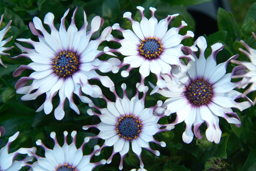

In [ ]:
from fastdownload import download_url
dest = 'Osteospermum.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "Dog photos":

Searching for 'dog photo'


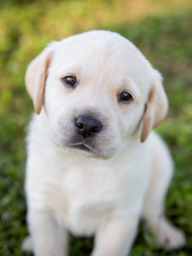

In [ ]:
download_url(search_images('dog photo', max_images=1)[0], 'Dog.jpg', show_progress=False)
Image.open('Dog.jpg').to_thumb(256,256)


Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [ ]:
import pandas as pd
import random

df = pd.read_csv("flower_names.csv")

searches = random.sample(df.latin.to_list(),100)

#searches = 'Osteospermum','Hippeastrum','Huechera','Hemerocallis','Phlox subulata','Astilbe japonica'
path = Path('flowers')
from time import sleep

In [ ]:
for o,n in enumerate(searches):
    print(f"{n} of {len(searches)}")
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(2)  # Pause between searches to avoid over-loading server
    #download_images(dest, urls=search_images(f'{o} sun photo'))
    #sleep(2)
    #download_images(dest, urls=search_images(f'{o} shade photo'))
    #sleep(2)
    #resize_images(path/o, max_size=400, dest=path/o)
    
print("\nDONE!")

Searching for 'Yarrow photo'
Searching for 'Silphium integrifolium photo'
Searching for 'Jamesia Americana photo'
Searching for 'Campsis radicans photo'
Searching for 'Trillium flexipes photo'
Searching for 'Sinningia speciosa photo'
Searching for 'Tricyrtis hirta photo'
Searching for 'Sprekelia formosissima photo'
Searching for 'Leucanthemum vulgare photo'
Searching for 'Bistorta officinalis photo'
Searching for 'Mirabilis jalapa photo'
Searching for 'Zephyranthes grandiflora photo'
Searching for 'Actinotus helianthi photo'
Searching for 'Nicotiana alata photo'
Searching for 'Ixia polystachya photo'
Searching for 'Aquilegia vulgaris photo'
Searching for 'Sarracenia leucophylla photo'
Searching for 'Lathyrus odoratus photo'
Searching for 'Hemerocallis photo'
Searching for 'Huechera photo'
Searching for 'Viola tricolor photo'
Searching for 'Epiphyllum oxypetalum photo'
Searching for 'Watsonia tabularis photo'
Searching for 'Chelone glabra photo'
Searching for 'Impatiens pallida photo'
S

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

51

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

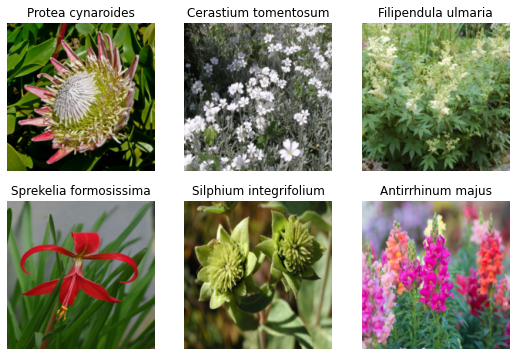

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,3.509016,1.873757,0.444676,03:40


epoch,train_loss,valid_loss,error_rate,time
0,1.399358,1.231490,0.319415,03:55


epoch,train_loss,valid_loss,error_rate,time
0,1.399358,1.231490,0.319415,03:55
1,0.782091,1.115907,0.267223,03:42
2,0.603621,1.103113,0.286013,03:40
3,0.444532,1.024107,0.270355,03:41
4,0.226861,0.906106,0.228601,03:40
5,0.116722,0.863390,0.220251,03:38
6,0.056593,0.801886,0.194154,03:39
7,0.027021,0.728849,0.179541,03:40
8,0.012963,0.721895,0.173278,03:41
9,0.008185,0.705709,0.174322,03:41


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

In [ ]:
learn.export('flower100_model.pkl')

from google.colab import files
files.download("flower100_model.pkl")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
#os.chdir(r'/kaggle/working')

!tar -czf flowers100_50each.tar.gz flowers

from IPython.display import FileLink

FileLink(r'flowers100_50each.tar.gz')
files.download("flowers100_50each.tar.gz")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
label_ind = [x for x,element in enumerate(learn.dls.vocab) if element == "Xerophyllum tenax"][0]
print(label_ind)

96


In [ ]:
learn.dls.vocab

['#na#', 'Aconitum napellus', 'Ageratum houstonianum', 'Alcea rosea', 'Amaranthus caudatus', 'Amaryllis belladonna', 'Anemone sylvestris', 'Asclepias speciosa', 'Clivia miniata', 'Coreopsis lanceolata', 'Daucus carota', 'Enemion biternatum', 'Fothergilla major', 'Fritillaria meleagris', 'Gaillardia pulchella', 'Hebe speciosa', 'Hemerocallis', 'Hydrangea arborescens', 'Ipomoea lobata', 'Justica carnea', 'Justicia rizzinii', 'Lathyrus latifolius', 'Liatris spicata', 'Linaria vulgaris', 'Narcissi', 'Nerine sarniensis', 'Osteospermum', 'Phyteuma orbiculare', 'Prunus triloba', 'Sedum', 'Tulipa']

In [ ]:
pred,_,probs = learn.predict(PILImage.create('Dog.jpg'))
print(f"This is an: {pred}.")
print(f"Probability: {probs[label_ind]:.4f}")
print()

This is an: Xerophyllum tenax.
Probability: 0.8809



## Performance

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

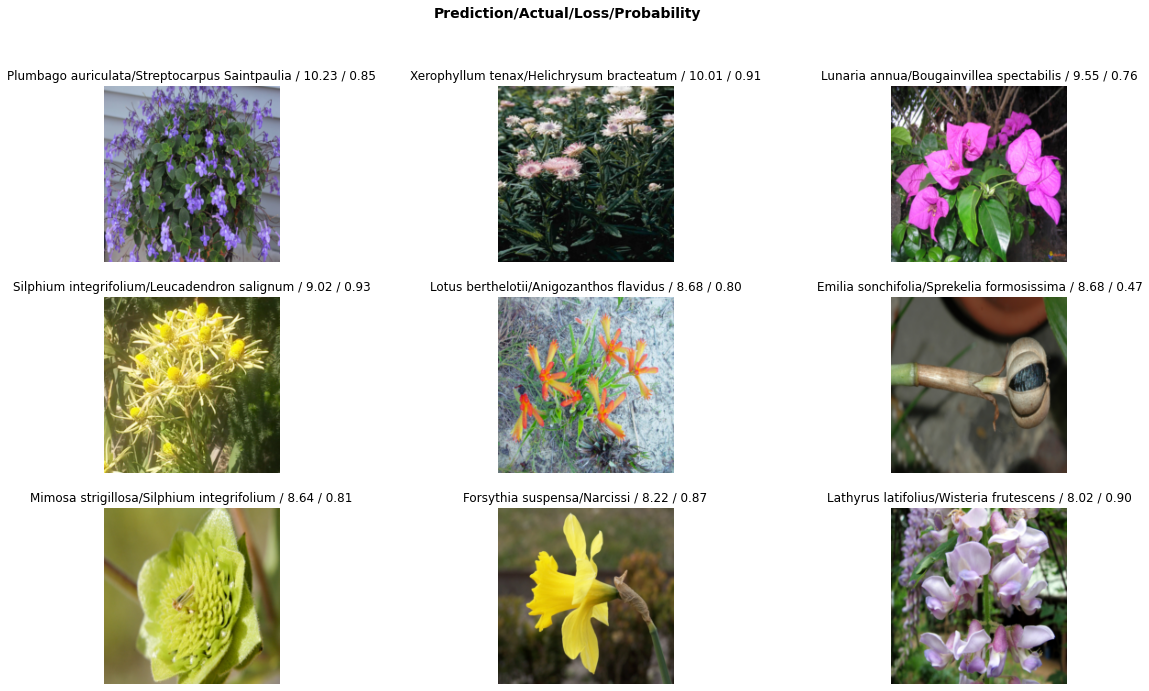

In [ ]:
interp.plot_top_losses(9, figsize=(20,11))

In [ ]:
interp.most_confused(min_val=2)

[('Lathyrus odoratus', 'Lathyrus latifolius', 3),
 ('Sprekelia formosissima', 'Amaranthus caudatus', 3),
 ('Anigozanthos flavidus', 'Amaranthus caudatus', 2),
 ('Anigozanthos flavidus', 'Lotus berthelotii', 2),
 ('Bougainvillea spectabilis', 'Lunaria annua', 2),
 ('Claytonia virginica', 'Zephyranthes grandiflora', 2),
 ('Emilia sonchifolia', 'Enemion biternatum', 2),
 ('Lathyrus odoratus', 'Dierama pulcherrimum', 2),
 ('Narcissi', 'Forsythia suspensa', 2),
 ('Silphium integrifolium', 'Forsythia suspensa', 2),
 ('Watsonia tabularis', 'Zephyranthes grandiflora', 2)]

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

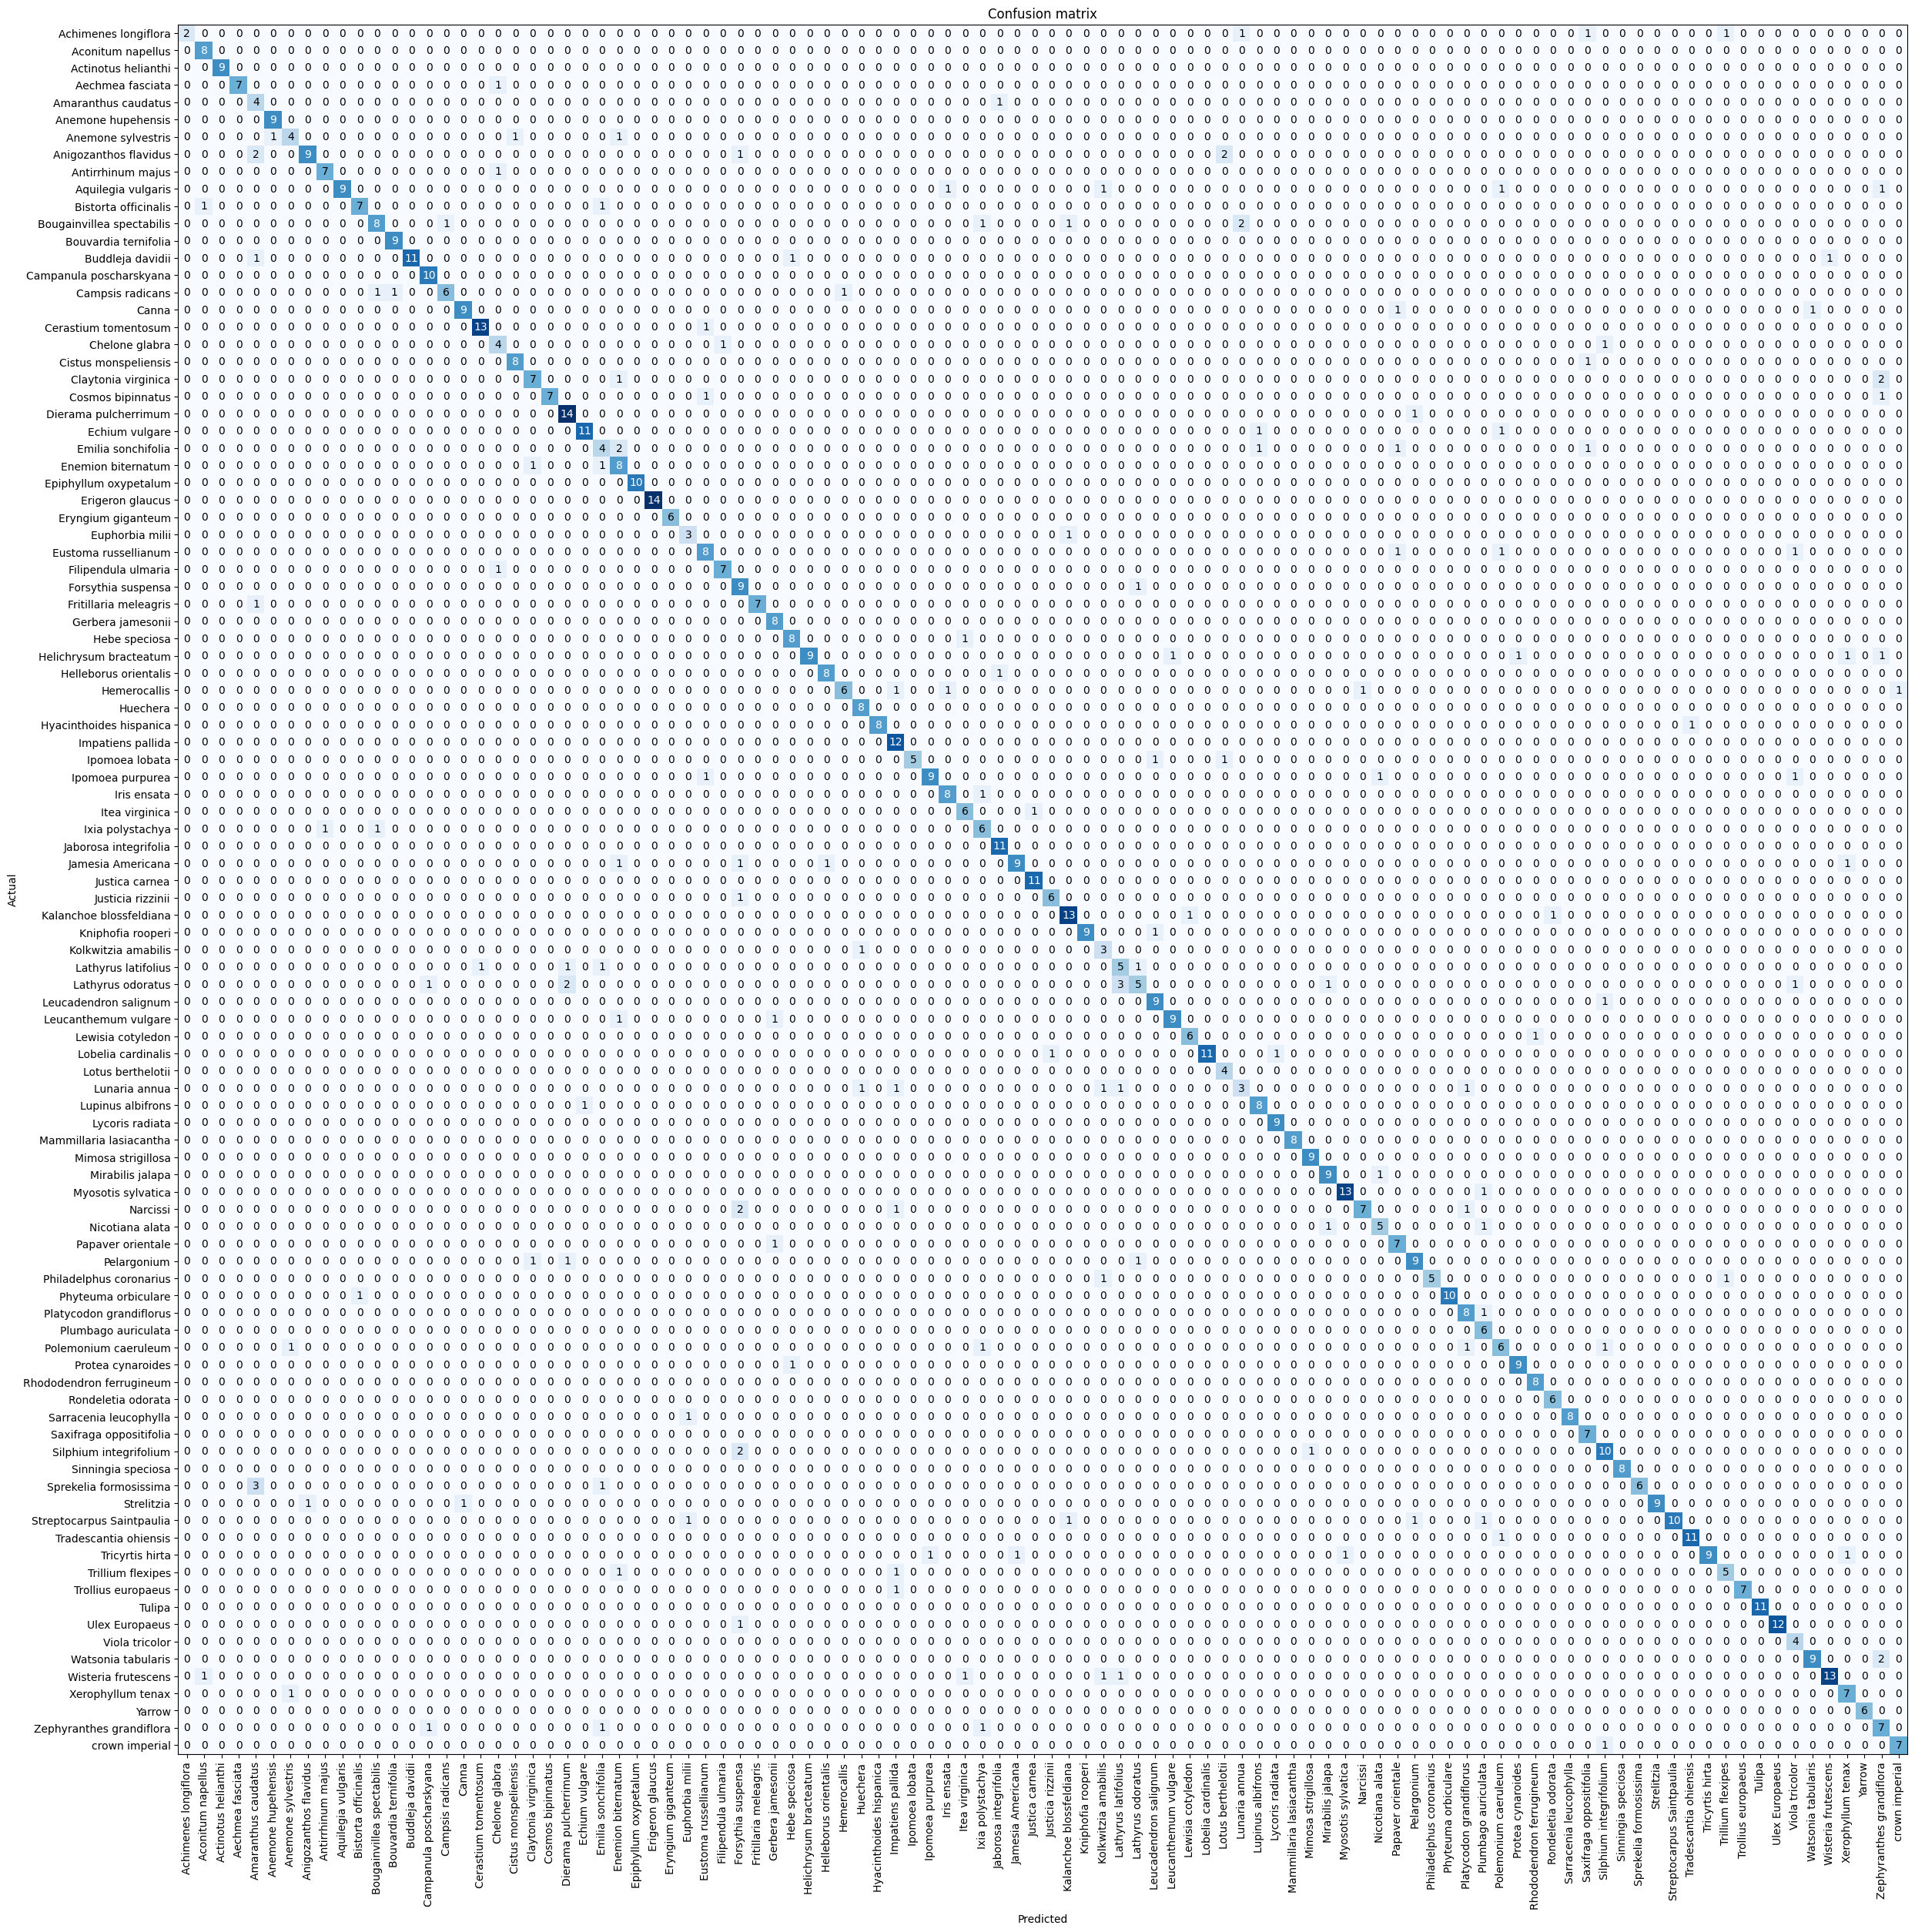

In [ ]:
interp.plot_confusion_matrix(figsize=(25,25), dpi=100)